
Through this project, you will:

> 1. Practice building, evaluating, and finetuning a convolutional neural network on an image dataset from development to testing. 
> 2. Gain a deeper understanding of feature maps and filters by visualizing some from a pre-trained network. 


### Setup and resources 

You must work using this provided template notebook.

Having a GPU will speed up the training process, especially for Question 1.3. See the provided document on Minerva about setting up a working environment for various ways to access a GPU.

Please implement the project using **Python and PyTorch**, and refer to the notebooks and exercises provided.

This project will use a subset of images from Tiny ImageNet, which is a subset of the ImageNet dataset [https://image-net.org/]. Our subset of Tiny ImageNet contains 30 different categories, we will refer to it as TinyImageNet30. The training set has 450 resized images (64x64 pixels) for each category (13,500 images in total). You can download the training and test set from the Kaggle website:




In [1]:
import cv2
import math
import csv
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.hub import load_state_dict_from_url
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torch import nn, optim
from numpy import argmax
import matplotlib.pyplot as plt





One challenge of building a deep learning model is to choose an architecture that can learn the features in the dataset without being unnecessarily complex. The first part of the project involves building a CNN and training it on TinyImageNet30. 

### **Overview:**
*   **1.1.1** PyTorch ```Dataset``` and ```DataLoader``` classes
*   **1.1.2** PyTorch ```Model``` class for simple CNN model
*   **1.1.3** Overfitting on a single batch
*   **1.2.1** Training on complete dataset
*   **1.2.2** Fine-tuning model
*   **1.2.3** Generating confusion matrices
*   **1.3**   Testing on test set on Kaggle


## 1.1 Single-batch training 

We will use a method of development called “single-batch training”, or "overfitting a single batch", in which we check that our model and the training code is working properly and can overfit a single training batch (i.e., we can drive the training loss to zero). Then we move on to training on the complete training set and adjust for any overfitting and fine-tune the model via regularisation.

### 1.1.1 Dataset class 



In [2]:
#Dataset class

class ImageFolderWithPaths(datasets.ImageFolder):
    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0][35:]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path




In [3]:
#dataset loading from custom loader
train_set = ImageFolder(root="./comp5623m-2022/train_set/train_set", transform=transforms.ToTensor())
test_set = ImageFolderWithPaths(root="./comp5623m-2022/test_set", transform=transforms.ToTensor())
train_set, val_set = torch.utils.data.random_split(train_set, [11500, 2000])
ROOT = './'

In [5]:
#creating loaders
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=64,
    shuffle=True,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    shuffle=False,
    num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

### 1.1.2 Define a CNN model [3 marks]

Create a new model class using a combination of convolutional and fully connected layers, ReLU, and max-pool. 

In [6]:
#creating a single batch
singBtch = next(iter(train_loader))

In [7]:
# define stats function
def stats(loader, net):
    correct = 0
    total = 0
    running_loss = 0
    n = 0   
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = net(images)      
            
            # accumulate loss
            running_loss += loss_fn(outputs, labels)
            n += 1
            
            # accumulate data for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)    
            correct += (predicted == labels).sum().item()  
            
    return running_loss/n, correct/total 

In [9]:
#defining the model 
net = nn.Sequential(
    nn.Conv2d(in_channels=3,out_channels=16, kernel_size=5),    
    nn.ReLU(),  
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=16,out_channels=64, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(64*13*13,96),     
    nn.ReLU(),
    nn.Linear(96,30),
    nn.Softmax()
)

### 1.1.3 Single-batch training 

Write the foundational code which trains your network given **one single batch** of training data and computes the loss on the complete validation set for each epoch. Set ```batch_size = 64```. 

Display the graph of the training and validation loss over training epochs, showing as long as necessary to show you can drive the training loss to zero.




In [ ]:
nepochs = 200
results_path = ROOT+'results/singBtch.pt'
statsrec = np.zeros((4,nepochs))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.003, momentum=0.9)
for epoch in range(nepochs) :  
    correct = 0         
    total = 0            
    running_loss = 0.0   
    n = 0                

    inputs, labels = singBtch


    optimizer.zero_grad()

    # Forward, backward, and update parameters
    outputs = net(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()

    # accumulate loss
    running_loss += loss.item()
    n += 1

    # accumulate data for accuracy
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)   
    correct += (predicted == labels).sum().item()  
    

    ltrn = running_loss/n
    atrn = correct/total 
    ltst, atst = stats(val_loader, net)
    statsrec[:,epoch] = (ltrn, atrn, ltst, atst)

torch.save({"state_dict": net.state_dict(), "stats": statsrec}, results_path)

In [11]:
#creating a function to trim zeroes
def trimZero(data):
    statsrec = [np.trim_zeros( data["stats"][0],'b')
    ,np.trim_zeros( data["stats"][1],'b')
    ,np.trim_zeros( data["stats"][2],'b')
    ,np.trim_zeros( data["stats"][3],'b')
    ]
    return statsrec

In [205]:
#function to plot charts
def plotChart(file) :
  results_path = file
  data = torch.load(results_path)
  statsrec = trimZero(data)
  plt.figure(figsize=(20, 10))
  plt.plot(statsrec[0], 'r', label = 'training loss', )
  plt.plot(statsrec[2], 'g', label = 'val loss' )
  plt.legend(loc='lower right')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('Training and validation loss')
  plt.legend(loc='upper right')
  plt.show()

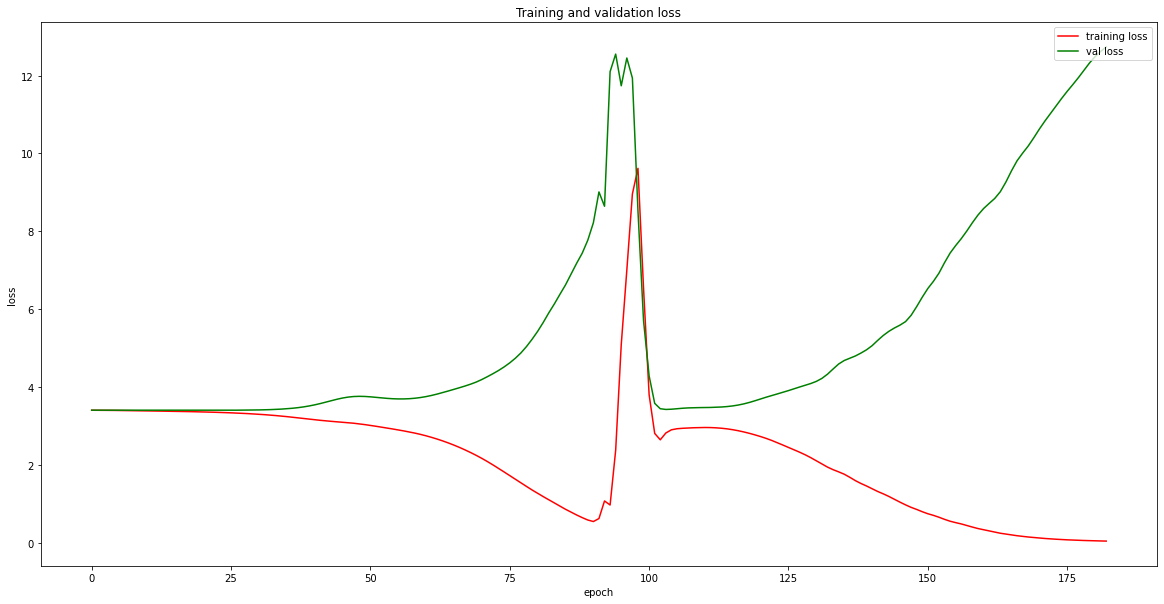

In [206]:
#something really weird happens at around 90 epoch
plotChart(ROOT+'results/singBtch.pt')



## 1.2 Training on complete dataset 

### 1.2.1 Train CNN and show loss graph 

Train your model on the complete training dataset, and use the validation set to determine when to stop training.

Display the graph of training and validation loss over epochs to show how you determined the optimal number of training epochs.




In [ ]:
#whole training set training 
nepochs = 50
results_path = ROOT+'results/wholeBtch.pt'
statsrec = np.zeros((4,nepochs))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.002, momentum=0.9)

for epoch in range(nepochs):  
    correct = 0         
    total = 0          
    running_loss = 0.0  
    n = 0               
    for data in train_loader:
        inputs, labels = data
        

        optimizer.zero_grad()


        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
        # accumulate loss
        running_loss += loss.item()
        n += 1
        

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)    
        correct += (predicted == labels).sum().item() 

    

    ltrn = running_loss/n
    atrn = correct/total 
    ltst, atst = stats(val_loader, net)
    statsrec[:,epoch] = (ltrn, atrn, ltst, atst)
torch.save({"state_dict": net.state_dict(), "stats": statsrec}, results_path)

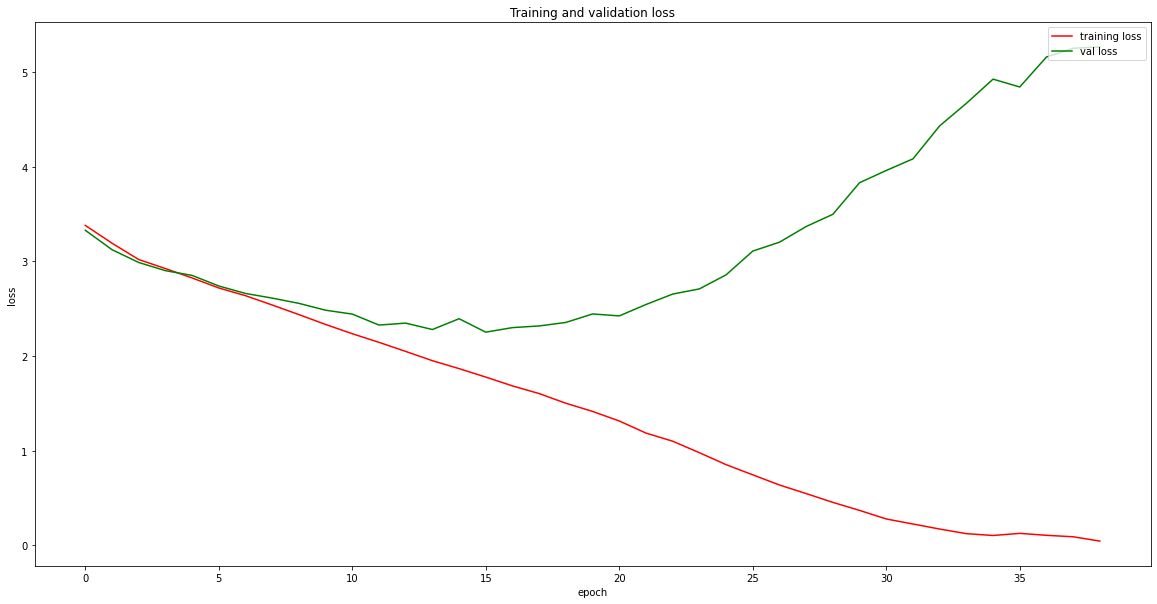

In [207]:
#Here the optimal number of epochs should be around 20 because after a point the model basically starts overfitting
plotChart(ROOT+'results/wholeBtch.pt')


### 1.2.2 Finetuning 




**Method 1:** Data augmentation of your choice

**Method 2:** Adding dropout and/or batch normalisation to the model

In [16]:

#defining transforms for data augmentation
transform_data = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.7),
    transforms.ColorJitter(hue=0.1, saturation=0.3, brightness=0.3),
    transforms.RandomPerspective(distortion_scale=0.3, p=1.0),
    transforms.RandomRotation(degrees=(0, 90)),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.RandomGrayscale(p=0.3),
    transforms.ToTensor()
])

In [17]:
#Data set realoading to transform and concatenate it
train_set1 = ImageFolder(root="./comp5623m-2022/train_set/train_set", transform=transform_data)
train_loader1 = torch.utils.data.DataLoader(
    train_set1,
    batch_size=64,
    shuffle=True,
    num_workers=2
)

final_dataset = torch.utils.data.ConcatDataset([train_set1,train_set])

train_aug_set, val_aug_set = torch.utils.data.random_split(final_dataset, [20000, 5000])


In [18]:
final_dataLoader= torch.utils.data.DataLoader(
    final_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2
)
val_aug_loader = torch.utils.data.DataLoader(
    val_aug_set,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

In [19]:
#new model with batch normalisation and augmentation in place
model_122a = nn.Sequential(
    nn.Conv2d(in_channels=3,out_channels=16, kernel_size=5),
    nn.BatchNorm2d(16),  
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=16,out_channels=64, kernel_size=5),
    nn.BatchNorm2d(64), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(64*13*13,96),
    nn.Dropout(p=0.5, inplace=False),

    nn.ReLU(),
    nn.Linear(96,30)
)
# (((W - K + 2P)/S) + 1)
  #   Here W = Input size
  #   K = Kernel size
  #   S = Stride
  #   P = Padding

for param in model_122a.parameters():
    print(param.shape)



torch.Size([16, 3, 5, 5])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([64, 16, 5, 5])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([96, 10816])
torch.Size([96])
torch.Size([30, 96])
torch.Size([30])


In [ ]:
#finetuned model
nepochs = 500
statsrec = np.zeros((4,nepochs))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_122a.parameters(), lr=0.001, momentum=0.9)

for epoch in range(nepochs):  
    correct = 0         
    total = 0           
    running_loss = 0.0   
    n = 0               
    for data in final_dataLoader:
        inputs, labels = data
        

        optimizer.zero_grad()


        outputs = model_122a(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
        # accumulate loss
        running_loss += loss.item()
        n += 1
        

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)   
        correct += (predicted == labels).sum().item()  
    

    ltrn = running_loss/n
    atrn = correct/total 
    ltst, atst = stats(val_aug_loader, model_122a)
    statsrec[:,epoch] = (ltrn, atrn, ltst, atst)

torch.save({"state_dict": model_122a.state_dict(), "stats": statsrec}, './augBN.pt')

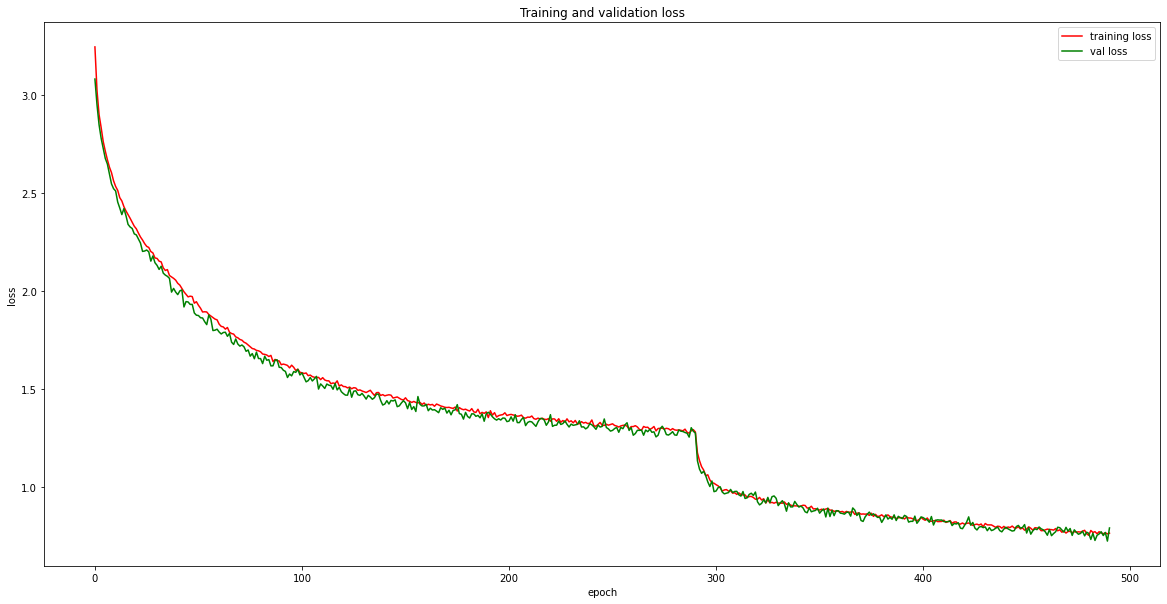

In [210]:
#something interesting happens at epoch 300
plotChart(ROOT+'./augBN.pt')



### 1.2.3 Training comparison 

Display, side-by-side or on one single graph, the training and validation loss graphs for the single-batch training (section 1.1.3), on the full training set (1.2.1) and your final fine-tuned model (1.2.2). 

In [99]:
#trimming the zeroes
statsrecSing = trimZero(torch.load('./results/singBtch.pt'))
statsrecFin = trimZero(torch.load('./results/wholeBtch.pt'))
statsrecAB = trimZero(torch.load('./augBN.pt'))

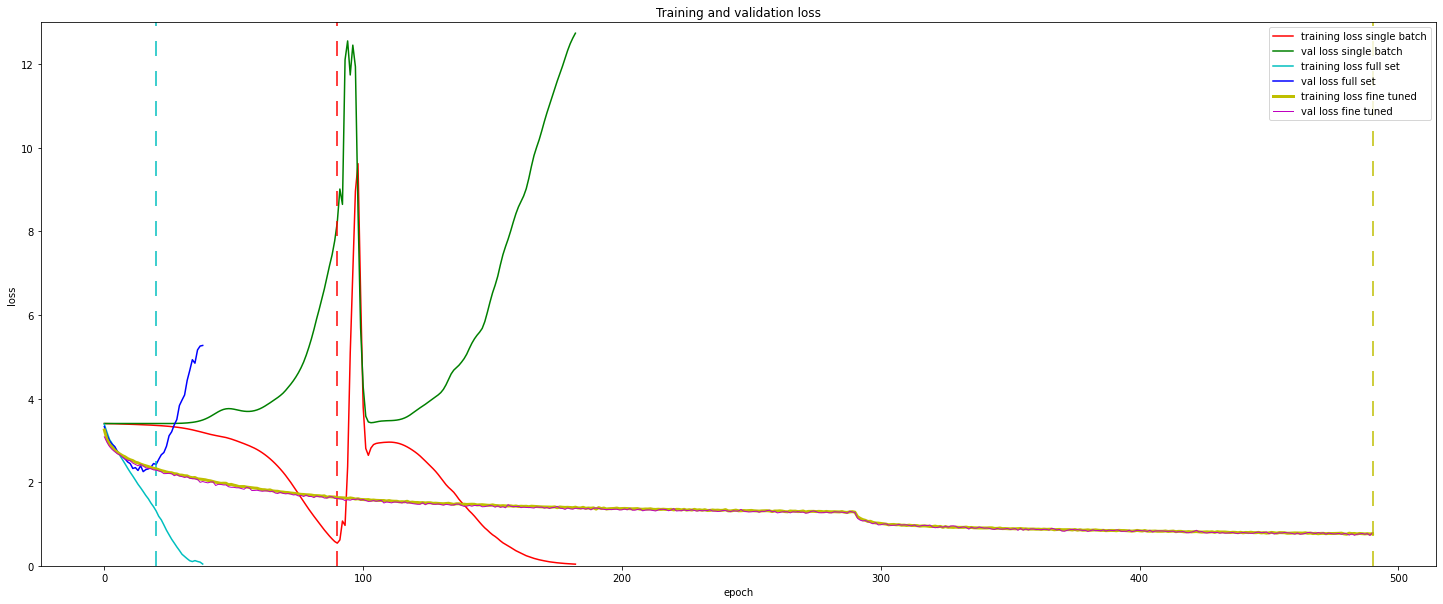

In [109]:
#preparing the chart
fig, ax1 = plt.subplots(figsize=(25,10))
ax1.set_ylim([0, 13])
plt.plot(statsrecSing[0], 'r', label = 'training loss single batch')
plt.plot(statsrecSing[2], 'g', label = 'val loss single batch' )
plt.axvline(x=90,color= 'r', dashes = (10,10))
plt.plot(statsrecFin[0], 'c', label = 'training loss full set', )
plt.plot(statsrecFin[2], 'b', label = 'val loss full set' )
plt.axvline(x=20,color= 'c', dashes = (10,10))
plt.plot(statsrecAB[0], 'y', label = 'training loss fine tuned', linewidth=3)
plt.plot(statsrecAB[2], 'm', label = 'val loss fine tuned', linewidth=1 )
plt.axvline(x=490,color= 'y', dashes = (10,10))
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.legend(loc='upper right')
plt.show()



**The vertical lines in the graph depict ideal epochs**


There is strong evidence to say single batch training performs the worst out of all the models we've trained. After a while single batch starts to overfit the training data and performs exponentially badly on the validation set. Full batch training, on the other hand, shows a reduction in the validation and training losses at first. But after a few epochs, the same thing starts happening again. The model starts overfitting the training set but basically worsens its predictions on the validation set. The fine-tuned model has very good training and validation loss over epochs and does well on the test set as well. It is safe to say that even though it took a lot of epochs to tune the model to be accurate, it gives safer predictions. After a while though, the losses plateau and we have to explicitly stop the training as the model doesn't improve anymore.


### 1.2.4 Confusion matrices 




In [230]:
#decimal truncating function
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

In [112]:
def accuracy(cnfm):
    return cnfm.trace()/cnfm.sum((0,1))

def recalls(cnfm):
    return np.diag(cnfm)/cnfm.sum(1)

def precisions(cnfm):
    return np.diag(cnfm)/cnfm.sum(0)    

In [231]:
#function for confusion matrix creation
def confusionM(loader):
    d = torch.load(ROOT+'augBN.pt')
    model_122a.load_state_dict(d["state_dict"])
    classes= np.arange(1,31)

    nclasses = classes.shape[0]
    cnfm = np.zeros((nclasses,nclasses),dtype=int)


    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model_122a(images)
            
            _, predicted = torch.max(outputs, 1)    
        
            

            for i in range(labels.size(0)):
                cnfm[labels[i].item(),predicted[i].item()] += 1
                
    cnfm = cnfm.astype(float)
    num = cnfm.sum(axis=1)
    cnfm = (cnfm / num[:, np.newaxis])*100
    cnfm = trunc(cnfm, decs=1)
    print("Confusion matrix")
    print(cnfm)
    plt.imshow(cnfm, cmap='gray')
    # show per-class recall and precision
    print(f"Accuracy: {accuracy(cnfm) :.1%}")
    r = recalls(cnfm)
    p = precisions(cnfm)
    for i in range(nclasses):
        print(f"Class {classes[i]} : Precision {p[i] :.1%}  Recall {r[i] :.1%}")


Confusion matrix
[[47.2  0.5  1.6  4.8  1.6  0.5  2.7  1.   7.   2.1  0.   0.   2.7  0.5
   0.   0.5  0.   0.5  8.6  2.1  3.8  0.5  0.5  4.3  0.   0.   3.8  0.
   1.   1. ]
 [ 0.5 47.3  1.1  0.5  0.5  2.9  1.1  1.1  0.   1.7  1.7  5.2  0.   1.1
   5.2  1.1  2.3  0.5  0.5  1.7  1.7  1.1  1.7  0.   4.   5.8  0.   5.2
   0.5  2.3]
 [ 1.   2.1 51.3  2.1  2.1  0.5  0.   3.7  0.   0.   6.4  2.1  1.   4.3
   0.5  1.   0.5  0.   2.7  8.6  0.   2.1  0.5  0.   1.   1.   1.6  0.5
   2.1  0. ]
 [ 1.3  0.   0.6 68.7  0.   0.   2.   1.3  6.8  0.   2.   0.6  2.   1.3
   0.   0.6  0.   0.   2.   0.6  4.   0.6  0.   0.6  0.   0.6  2.   0.
   0.6  0.6]
 [ 0.5  0.   3.5  0.  81.1  0.   0.   0.   0.   0.   1.1  0.   0.5  3.5
   0.5  1.1  0.   0.   1.1  1.1  0.5  1.1  0.   0.   0.   0.   0.5  0.5
   0.   2.3]
 [ 0.   4.7  0.5  0.   0.5 39.8  1.1  4.7  0.   3.5  0.5  3.5  3.5  0.
   7.7  5.9  2.3  4.7  0.   1.1  1.1  1.7  1.7  0.   1.1  1.7  0.5  2.9
   1.7  1.7]
 [ 1.2  0.   0.   1.8  0.6  1.8 66.4  0.   2

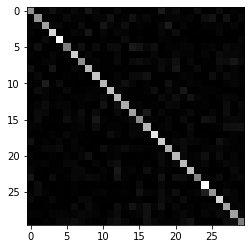

In [232]:
#Validation set confusion matrix depicting percentage of data at each position
confusionM(val_aug_loader)

Confusion matrix
[[47.1  0.1  0.5  5.2  0.4  0.2  1.3  1.5  6.1  0.3  0.9  0.3  2.7  0.3
   0.1  1.1  0.5  0.3  6.3  0.5  8.4  1.6  1.1  3.6  0.9  0.5  3.5  0.9
   1.1  0.8]
 [ 0.4 47.1  1.5  1.   0.2  3.1  1.3  1.   0.4  3.   1.3  3.   1.7  2.3
   4.7  2.5  3.   0.3  1.4  1.7  1.2  2.   1.8  0.6  2.5  3.6  0.2  2.4
   1.7  1.7]
 [ 0.5  1.  51.7  0.4  5.8  0.3  0.2  2.3  0.3  0.  10.   0.9  1.9  2.2
   1.4  0.9  0.4  0.2  0.9  6.7  1.4  1.5  0.5  0.1  1.5  0.5  2.3  0.5
   1.1  0.8]
 [ 2.9  0.   0.4 68.7  0.   0.2  1.6  0.7  6.5  0.3  1.1  0.2  2.6  0.2
   0.1  0.3  0.4  0.7  1.4  0.3  2.   0.8  0.3  2.   0.2  0.   2.3  0.2
   0.5  1.6]
 [ 0.1  0.6  3.   0.1 77.   0.   0.2  0.2  0.2  0.   2.7  0.1  1.   2.5
   0.4  0.3  0.7  0.2  1.5  2.8  0.1  0.9  0.3  0.   0.9  0.4  0.3  0.3
   0.6  1.3]
 [ 0.2  3.3  1.4  0.6  0.9 50.3  1.   3.1  0.4  2.4  0.4  3.   1.   0.
   4.5  3.9  2.6  2.4  0.3  1.2  1.2  1.6  1.6  0.4  1.5  2.2  0.7  2.4
   2.1  2. ]
 [ 1.5  0.9  0.1  0.9  0.6  0.1 65.4  0.8 

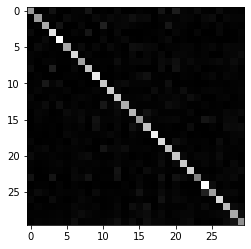

In [233]:
#Training set confusion matrix depicting percentage of data at each position
confusionM(final_dataLoader)

The accuracy of both the models is coming pretty close from confusion matrix. Classes 4, 5 and 18 have the best precision and recall among all classes in validation set and training set confusion matrix. The matrices suggest varied and pretty skewed precisions and accuracies for the different classes. 



## 1.3 Testing on test data 

### 1.3.1 Dataset and generating predictions 



In [196]:
#function for creating the predictions in a .pt file
statTest = np.zeros(1501)
names = []
def evaluate_model(test_dl, model):
    for i, inputs in enumerate(test_dl):
        names.append(inputs[2][0])
        yhat = model(inputs[0])
        yhat = yhat.detach().numpy()
        yhat = argmax(yhat, axis=1)
        yhat = yhat.reshape((len(yhat), 1))
        statTest[i] = (yhat)

    torch.save({"stats": statTest}, './at.pt')

In [197]:
#model predictions on test data
evaluate_model(test_loader, model_122a)


### 1.3.2 CSV file and test set accuracy 

The CSV file must contain only two columns: ‘Id’ and ‘Category’ (predicted class ID) as shown below:

```txt
Id,Category
28d0f5e9_373c.JPEG,2
bbe4895f_40bf.JPEG,18
```



In [211]:
#creating the csv file
header = ['Id', 'Category']
with open('mm21is.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    writer.writerow(header)

    
    for i in range(0,1500): 
        writer.writerow([names[i],int(statTest[i])])



## QUESTION 2



visualize the filters and feature maps of a fully-trained CNN (AlexNet) on the full ImageNet 2012 dataset.


### **Overview:**
*   **2.1.1** Extract filters from model: ``fetch_filters(layer_idx, model)``
*   **2.2.1** Load test image
*   **2.2.2** Extract feature maps for given test image: ``fetch_feature_maps(image, model)``
*   **2.2.3** Display feature maps
*   **2.3.1** Generate Grad-CAM heatmaps: ``generate_heatmap(output, class_id, model, image)``
*   **2.3.2** Display heatmaps: add code to cell
*   **2.3.3** Generate heatmaps for failure analysis


### Loading a pre-trained model

Run the cell below to load an AlexNet model with pre-trained weights.

In [119]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
model.eval()

Using cache found in /Users/itish/.cache/torch/hub/pytorch_vision_v0.6.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [120]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [121]:
model.features[0]

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

In [122]:
model.features[0].weight.shape

torch.Size([64, 3, 11, 11])


## 2.1 Extract and visualize the filters 



### 2.1.1 Extract filters 


In [123]:
def fetch_filters(layer_idx, model):
    """ 
        Args:
            layer_idx (int): the index of model.features specifying which conv layer
            model (AlexNet): PyTorch AlexNet object
        Return:
            filters (Tensor):      
    """
    conv1 = model.features[layer_idx]
    weight = conv1.weight.data.numpy()
    print(weight)
    return weight
  

In [ ]:
# all the indices of the conv layers
conv_layer_idx = [0, 3, 6, 8, 10]

filters = []

for layer_idx in conv_layer_idx:
    filters.append(fetch_filters(layer_idx, model))

For your testing purposes, the following code blocks test the dimensions of the function output.

In [125]:
filters[0].shape

(64, 3, 11, 11)

In [126]:
assert list(filters[0].shape) == [64, 3, 11, 11]



### 2.1.2 Display filters 

The following code will visualize some of the filters from each layer. Play around with viewing filters at different depths into the network. Note that ```filters[0]``` could be viewed in colour if you prefer, whereas the subsequent layers must be viewed one channel at a time in grayscale. 



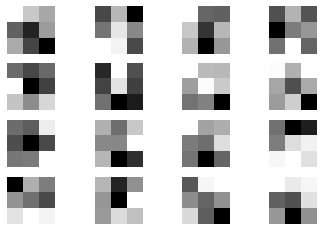

In [139]:
# limit how many filters to show
to_show = 16
filters = np.array(filters,dtype='object')

# compute the dimensions of the plot
plt_dim = int(math.sqrt(to_show))
# plot the first channel of each filter in a grid
for i, filt in enumerate(filters[4][:to_show]):
    plt.subplot(plt_dim, plt_dim, i+1)
    plt.imshow(filt[0], cmap="gray")
    plt.axis('off')
plt.show()



## 2.2 Extract and visualize feature maps 




### 2.2.1 Load test image


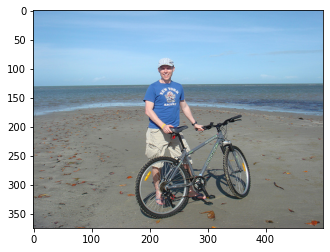

In [140]:
# TO COMPLETE
im = plt.imread('man_bike.JPEG')
plt.imshow(im)

Run the code cell below to apply the image transformation expected by the model.

In [141]:
# ImageNet normalisation values, to apply to the image transform
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

data_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

im = data_transform(im)


### 2.2.2 Extract feature maps 

Complete the function below to pass the test image through a single forward pass of the network. We are interested in the outputs of the max pool layers (outputs of conv layers at model.features indices 0, 3, and 10) for best visualization. Note that the input should pass through *every layer* of the model.

In [143]:
def fetch_feature_maps(image, model):
    """
    Args:
        image (Tensor): a single input image with transform applied
        model (AlexNet): PyTorch AlexNet object
        
    Return:
        feature_maps (Tensor): all the feature maps from conv layers 
                    at indices 0, 3, and 10 (outputs of the MaxPool layers)
    """
    results = [model.features[0](image)]
    for i in range(1, len(model.features)):
        if i == 2 or i == 5 or i == 12:
            results.append(model.features[i](results[-1]))
            output = results
    output.pop(0)
    return output


In [144]:
feature_maps = fetch_feature_maps(im.unsqueeze(0), model)

For your testing purposes, the following code block tests the dimensions of part of the function output. Note that the first dimension is the batch size.

In [145]:
assert len(feature_maps) == 3
assert list(feature_maps[0].shape) == [1, 64, 31, 31]



### 2.2.3 Display feature maps 

Using the code for displaying filters as reference, write code in the block below to display the outputs of the first **16 feature maps from each of the 3 max-pool layers**.

Layer  1


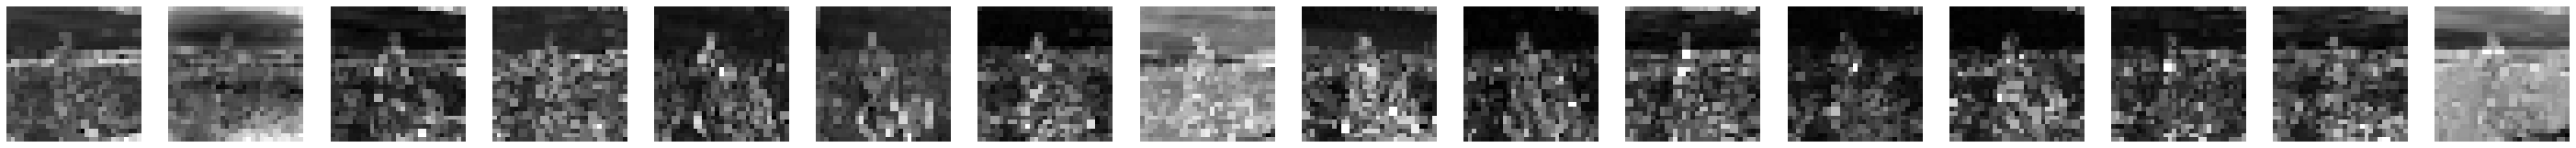

Layer  2


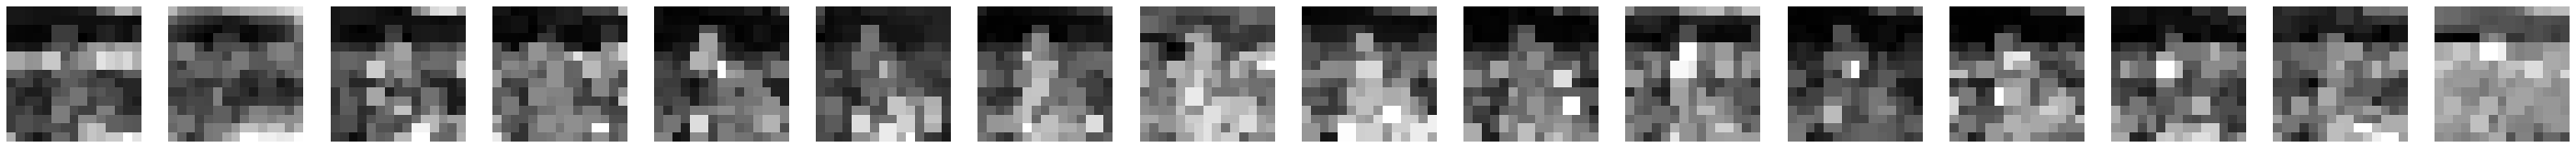

Layer  3


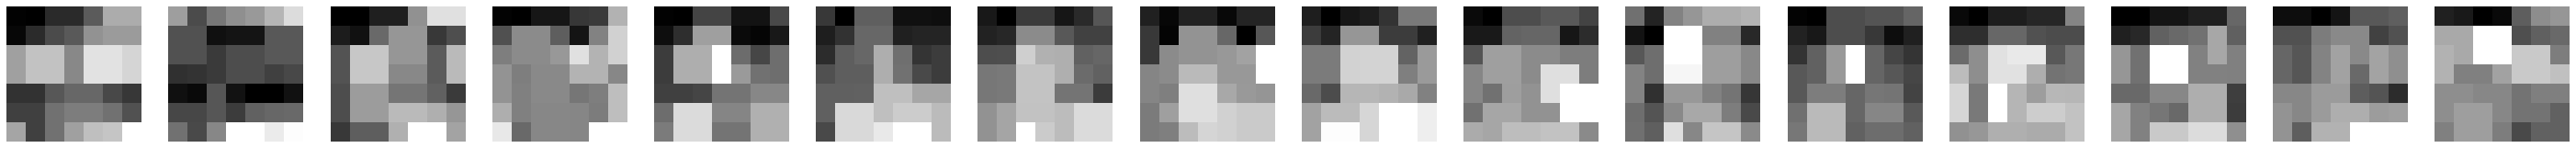

In [15]:
# # TO COMPLETE
to_show = 16
plt_dim = int(math.sqrt(to_show))
for l in range(len(feature_maps)):
    plt.figure(figsize=(50, 50))
    data = feature_maps[l][0, :, :, :]
    data  = data.data
    print("Layer number ", l+1)
    for i, filter in enumerate(data):
        if i == 16:
            break
        plt.subplot(plt_dim, to_show, i+1)
        plt.imshow(filter, cmap="gray")
        plt.axis('off')
    plt.show()
    plt.close()

The first filter at index 0 is trying to figure out the edges and lines which will distinguish each object in the image from everything else. It is trying to concentrate on differentiating the object in the image we're supposed to predict. Both the man and the bicycle edges are coming out nicely in the 0th index. 
The 4th index is learning patterns. And from the output in layer 2, it can be seen that it's trying to learn the pattern of the bicycle. It's mainly focusing on the wheels or the metal part of the bicycle and trying to learn from it. 
The filter at index 6 is focusing more on the man's face. An inference from it can be drawn that it's trying to detect the man in the image from everything else. As we grow deeper and deeper into the network such inferences are bound to happen. Each filter is supposed to figure a different pattern to distinguish it from the image. This detection is fairly demonstrated in the Layer outputs above.

A filter in a network is responsible to learn more and more complex patterns exhibited in an image. It starts off with simple patterns, hence fewer filters. As it goes deeper into the network we're supposed to teach our model more and more complex patterns, which are not small in size. So as the number of patterns and their complexity in our network grows with depth, the filter size increases as well while passing through each layer. Alexnet serves as an example wherein filters start from 64 and go up to values such as 192 and such.

Feature maps are a result of applying filters to the input image in the first layer, and to the output of prior layers in the subsequent layers. They refer to the features that help in classifying an image to its correct class, like wheels in a bicycle would play an important role in classifying it as a bicycle for an instance. 
With depth, feature maps' size increases, it has a 3-dimensional shape that is extended with every layer and can cause problems because of an insurmountable number of feature maps. This is an exhaustive computational issue. To tackle this Pooling layers are used to downscale feature maps and systematically halve the width and height of feature maps in the network.


## 2.4 Gradient-weighted Class Activation Mapping (Grad-CAM) 

In this section, we will explore using Gradient-weighted Class Activation Mapping (Grad-CAM) to generate coarse localization maps highlighting the important regions in the test images guiding the model's prediction. We will continue using the pre-trained AlexNet.

#### Preparation
>It is recommended to first read the relevant paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391), and refer to relevant course material.

#### The AlexNet class

>To implement Grad-CAM, we need to edit the AlexNet ```module``` class itself, so instead of loading the AlexNet model from ```torch.hub``` as we did above, we will use the official PyTorch AlexNet class code ([taken from here](https://pytorch.org/vision/stable/_modules/torchvision/models/alexnet.html)). In addition to the class definition, there is also a function below called ```alexnet()``` which allows you to specify whether you want the pretrained version or not, and if so, loads the weights. 

#### The hook

>[Hooks](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) in PyTorch are functions which can be registered, or attached, to a ```Module``` or ```Tensor```. Hooks can be *forward* hooks or *backward* hooks; forward hooks are called with ```forward()``` and backward hooks with ```backward()```. In the model below, we register a forward hook that saves the **gradients of the activations** to the Tensor output of ```model.features```. The gradients are saved to a class variable so we can easily access them.

Carefully read the code block below. You do not need to add anything to the model.

In [146]:
# defining where to load the pre-trained weights from
model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-7be5be79.pth',
}

# the class definition
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        
        # a placeholder for storing the gradients
        self.gradients = None
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        
    # the hook for the gradients of the activations
    def activations_hook(self, grad):
        # stores the gradients of the hook's tensor to our placeholder variable
        self.gradients = grad

    # a method for extracting the activations of the last conv layer only (when we're 
    # not interested in a full forward pass)
    def get_activations(self, x):
        return self.features(x)
    
    def forward(self, x):
        x = self.features(x)
        
        # we register the hook here to save the gradients of the last convolutional
        # layer outputs
        hook = x.register_hook(self.activations_hook)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
        

def alexnet(pretrained=False, progress=True, **kwargs) -> AlexNet:
    """AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [147]:
model = alexnet(pretrained=True)

In [148]:
# pass our test image through our new model with the hook
output = model(im.unsqueeze(0))

# save the predicted class
_, pred_cls = output.max(dim=1, keepdim=True)

Examine and understand the values stored in ```output``` and ```pred_cls```. What does AlexNet classify the test image as?

In [ ]:
pred_cls, output

In [150]:
prob = torch.nn.functional.softmax(output[0], dim=0)
print(prob[pred_cls])

tensor([[0.4997]], grad_fn=<IndexBackward0>)


In [151]:
def predict(cls,prob):
  with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
  print(categories[cls])
  # Show top categories per image|
  top3_probab, top3_categid = torch.topk(prob, 3)
  for i in range(top3_probab.size(0)):
      print(categories[top3_categid[i]], top3_probab[i].item())

In [152]:
predict(pred_cls,prob)

mountain bike
mountain bike 0.49967578053474426
bicycle-built-for-two 0.37043479084968567
moped 0.07737982273101807


Alexnet is classifying the image as a mountain bike.

### 2.4.1 Generate Grad-CAM heatmaps 

With the hooks in place, now implement the code to generate Grad-CAM heatmaps, by following the guiding comments in the code block below.

In [154]:
def generate_heatmap(output, class_id, model, image):
    
    # 1. compute the gradient of the score for the predicted class (logit)
    # with respect to the feature map activations of the last convolutional layer
    # Hint: calling .backward() on a Tensor computes its gradients
    # TO COMPLETE
    output[:,class_id].backward(retain_graph=True)
    # 2. get the gradients from the model placeholder variable
    # TO COMPLETE
    gradients = model.gradients
    assert list(gradients.shape) == [1, 256, 7, 7]
    
    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    assert list(pooled_gradients.shape) == [256]
    
    # 3. get the activations of the last convolutional layer
    # TO COMPLETE
    activations = model.get_activations(image).detach()
    assert list(activations.shape) == [1, 256, 7, 7]
    
    # 4. weight (multiply) the channels (dim=1 of activations) by the corresponding
    # gradients (pooled_gradients)
    # TO COMPLETE
    for i in range(256):
        activations[:, i, :, :] *= pooled_gradients[i]
    # average the channels of the activations and squeeze out the extra dimension
    heatmap = torch.mean(activations, dim=1).squeeze()
    assert list(heatmap.shape) == [7, 7]
    
    # 5. apply a ReLU to the linear combination of maps because we are only 
    # interested in the features that have a positive influence on the class of 
    # interest, i.e. pixels whose intensity should be increased in order to increase y
    # Hint: you can use np.maximum() and torch.max() to perform ReLU if you prefer.
    
    # TO COMPLETE
    heatmap = np.maximum(heatmap, 0)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)
    # TO COMPLETE
    return heatmap

In [155]:
heatmap = generate_heatmap(output, pred_cls, model, im.unsqueeze(0))

Check the dimensions of ```heatmap```. Do they make sense?

In [158]:
heatmap.shape

torch.Size([7, 7])

### 2.4.2 Display heatmaps 

Display ```heatmap``` as a coloured heatmap super-imposed onto the original image. To get results as shown in the paper, we recommend the following steps:

1. Resize the heatmap to match the size of the image.
2. Rescale the image to a 0-255 integer range.
3. Apply a colormap to the heatmap using ```cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)```.
4. Multiply all values of heatmap by 0.4 to reduce colour saturation.
5. Superimpose the heatmap onto the original image (Note: please perform cv2's addition - addition of two cv2 images, not numpy addition. See [here](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_core/py_image_arithmetics/py_image_arithmetics.html#:~:text=addWeighted()%20etc.-,Image%20Addition,OpenCV%20addition%20and%20Numpy%20addition.) for explanation.)
6. Normalize the image between 0-255 again.
7. Display the resulting image.

In [161]:
#function for displaying the heatmap
def dHM(name, out, hm) :
  image = cv2.imread(name)
  hm = cv2.resize(np.float32(hm), (image.shape[1], image.shape[0]))
  hm = np.uint8(255 * hm)
  hm = cv2.applyColorMap(hm, cv2.COLORMAP_JET)
  s_img = hm * 0.4 + image
  s_img*= 255.0/s_img.max()
  cv2.imwrite(out, s_img)


In [162]:
dHM('man_bike.JPEG','./heat_ma1.jpg', heatmap)

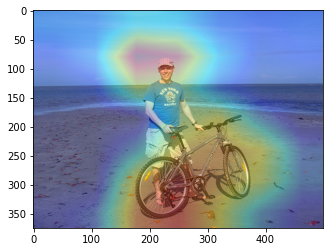

In [163]:
#mountain bike features brighten up
superimposed = plt.imread('heat_ma1.jpg')
plt.imshow(superimposed)

Show the heatmap for class ```'seashore, coast, seacoast, sea-coast'``` (```class_id = 978```), super-imposed onto the original image.

In [164]:

heatmap1 = generate_heatmap(output, 978, model, im.unsqueeze(0))

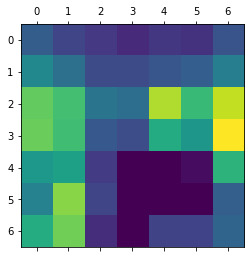

In [165]:
plt.matshow(heatmap1.squeeze())

In [166]:
dHM('man_bike.JPEG','./shore.jpg', heatmap1)

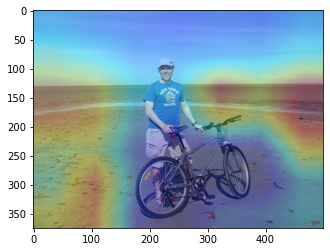

In [167]:
#shore features brighten up
super_impose = plt.imread('./shore.jpg')
plt.imshow(super_impose)

### 2.4.3 Failure analysis using Grad-CAM 

Find an image (online, or from ImageNet or another dataset) which AlexNet classifies *incorrectly*. Display the image below, and show the model's predicted class. Then, generate the Grad-CAM heatmap and display it super-imposed onto the image.

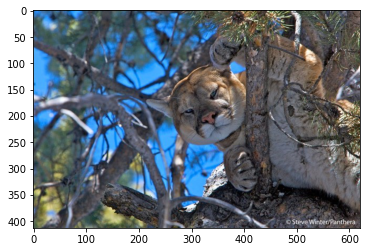

In [185]:
# image of a cougar
image = plt.imread('cog.jpeg')
plt.imshow(image)

In [186]:
image = data_transform(image)

In [187]:
# pass our test image through our new model with the hook
output = model(image.unsqueeze(0))

# save the predicted class
_, pred_cls = output.max(dim=1, keepdim=True)
prob1 = torch.nn.functional.softmax(output[0], dim=0)
print(pred_cls)

tensor([[24]])


In [188]:
predict(pred_cls,prob1)

great grey owl
great grey owl 0.16572630405426025
cougar 0.1479111909866333
leopard 0.08462340384721756


In [189]:
heatmap2 = generate_heatmap(output, pred_cls, model, im.unsqueeze(0))

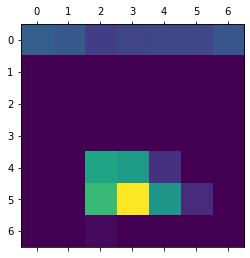

In [190]:
plt.matshow(heatmap2.squeeze())

In [191]:
dHM('cog.jpeg','./mapped_cob.jpg',heatmap2)

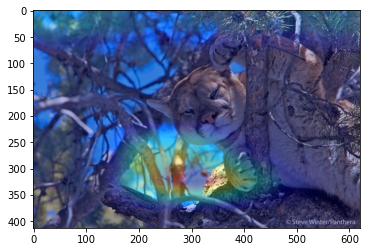

In [192]:
super_impose = plt.imread('mapped_cob.jpg')

plt.imshow(super_impose)

The image here has a cougar looking over from a bunch of branches. These branches can easily confuse a model because of the random patters that they inherit which can mimic any other class. The easiest explaination for this is how a human sometimes mistakes a chair with clothes on it as a person in dark. Something of similar extent is happening here. We can see that the highlighted part finds a great grey owl in the image. It can be assumed that this section therefore with so many branches in it is looking like an owl to Alexnet.